In [1]:
%cd /kaggle/working

/kaggle/working


In [2]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime
import sys
from tqdm import tqdm
import os
import random
import pickle
from glob import glob
import gc
from multiprocessing import Pool, cpu_count

import torch
import torch.nn as nn
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau

# CV
from PIL import Image

import pytorch_lightning as pl
from torchmetrics import MetricCollection, MeanSquaredError
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle')
from utils.xgb import fit_xgb, inference_xgb
from utils.metric import compute_comptetition_metric
from utils.feature_contena import Features
from utils.pandas_utils import reduce_mem_usage
from utils.lightning_utils import MyLightningDataModule
from utils.torch_models import Conv1dBnRelu

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-09-25 12:09:13.412107: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib
2023-09-25 12:09:13.412179: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib

In [3]:
config = f"""
execution:
    exp_id: exp_022
    debug: False
    submit: False
    multiprocessing: True

dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv
    train_base_path: /kaggle/input/train_base/train_base.csv
    step_csv_dir: /kaggle/input/save_series_csv/csvs

    oof_exp_ids: [exp_015, exp_020, exp_021]

feature:
    agg_freq: 24 # [step]

xgboost:    
    objective: "binary:logistic"
    learning_rate: 0.1  # 0.01で固定。学習時間とのトレードオフ
    reg_alpha: 0.02  # L1正則化。0.1が推奨。
    reg_lambda: 0.2  # L2正則化。0.1が推奨
    random_state: 42
    max_depth: 5  # 3-8。7くらいでいい。
    colsample_bytree: 0.7  # カラムが多い時は少なめ(0.4とか)にする。
    
seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

CFG["output_dir"] = f"/kaggle/output/{CFG['execution']['exp_id']}"
os.makedirs(CFG["output_dir"], exist_ok=True)

In [4]:
class ZzzMetaDataset(Dataset):
    def __init__(self, dfs: list[pd.DataFrame], mode: str):
        self.dfs = dfs
        self.mode = mode

    def __len__(self):
        return len(self.dfs)

    def __getitem__(self, index):
        df = self.dfs[index]

        feats = df[[f"oof_{i}" for i in range(len(CFG["dataset"]["oof_exp_ids"]))]].values.astype(np.float32)

        if self.mode == "train":
            targets = df["target"].values.astype(np.float32)
            return feats, targets
        else:
            return feats

In [5]:
class MetaCNNModule(pl.LightningModule):
    def __init__(self, loss_fn=nn.CrossEntropyLoss(), lr=0.001, weight_decay=0):
        super().__init__()
        
        self.block1 = Conv1dBnRelu(len(CFG["dataset"]["oof_exp_ids"]), 48)
        self.block2 = Conv1dBnRelu(48, 72)
        self.block3 = Conv1dBnRelu(72, 108)
        self.head = nn.Sequential(
            nn.Linear(108, 32),
            nn.LeakyReLU(0.1),
            nn.Linear(32, 1),
        )

        self.loss_fn = loss_fn
        self.lr = lr
        self.weight_decay = weight_decay

        self.train_metrics = MetricCollection([], prefix="")
        self.valid_metrics = MetricCollection([], prefix="val_")
        
        self.val_step_outputs = []
        self.val_step_labels = []

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = x.permute(0, 2, 1)
        x = self.head(x).squeeze(-1)
        return x

    def training_step(self, batch, batch_idx):
        X, y = batch
        preds = self.forward(X)

        loss = self.loss_fn(preds, y)

        self.train_metrics(preds, y)
        self.log("loss", loss, prog_bar=True, logger=True, on_epoch=True, on_step=True,)
        self.log_dict(self.train_metrics, prog_bar=True, logger=True, on_epoch=True, on_step=True,)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        X, y = batch
        preds = self.forward(X)
        
        self.val_step_outputs.append(preds)
        self.val_step_labels.append(y)

    def on_validation_epoch_end(self):
        preds = torch.cat(self.val_step_outputs)
        labels = torch.cat(self.val_step_labels)
        self.val_step_outputs.clear()
        self.val_step_labels.clear()
        loss = self.loss_fn(preds, labels)

        self.valid_metrics(preds, labels)
        self.log("val_loss", loss, prog_bar=False, logger=True, on_epoch=True, on_step=False,)
        self.log_dict(self.valid_metrics, prog_bar=False, logger=True, on_epoch=True, on_step=False,)

        # ログをprint
        self.print_metric(preds, labels, "valid")

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=3, verbose=True)
        return {"optimizer": optimizer, 
                "lr_scheduler": scheduler, 
                "monitor": "val_loss"}
                
    def print_metric(self, y_hat, y, train_or_valid="train"):
        """
        ログをprintする。次のepochが終わると上書きされてしまうので。
        TODO: たぶんもっとマシな方法があるので探す。
        """
        if train_or_valid == "train":
            metrics = self.train_metrics
        else:
            metrics = self.valid_metrics
        loss = self.loss_fn(y_hat, y)

        print(f"[epoch {self.trainer.current_epoch}] {train_or_valid}: ", end="")
        print(f"{type(self.loss_fn).__name__}={loss:.4f}", end=", ")
        for name in metrics:
            v = metrics[name](y_hat, y)
            print(f"{name}={v:.4f}", end=", ")
        print()

In [6]:
dfs = []
for exp_id in CFG["dataset"]["oof_exp_ids"]:
    df = pd.read_csv(f"/kaggle/output/{exp_id}/oof.csv")
    df["oof"] = df["raw_oof"].fillna(1)
    df = df[["target", "step", "series_id", "oof", "fold"]]
    dfs.append(df)

train = dfs[0]
train.rename(columns={"oof": "oof_0"}, inplace=True)
for i, df in enumerate(dfs[1:]):
    df.rename(columns={"oof": f"oof_{i + 1}"}, inplace=True)
    train = train.merge(df[["series_id", f"oof_{i + 1}", "step"]], on=["series_id", "step"], how="left")
train.head()

,target,step,series_id,oof_0,fold,oof_1,oof_2
0,1,11.5,038441c925bb,0.999819,2,0.993235,0.995310
1,1,35.5,038441c925bb,0.999644,2,0.994456,0.993991
2,1,59.5,038441c925bb,0.993865,2,0.995319,0.994398
3,1,83.5,038441c925bb,0.995005,2,0.996053,0.994453
4,1,107.5,038441c925bb,0.994551,2,0.996560,0.994324


In [7]:
SEQ_LEN = 300

# SEQ_LEN ごとに分割
dfs = []
for series_id, df in tqdm(train.groupby("series_id")):
    df = df.sort_values("step")

    for start in range(0, len(df), SEQ_LEN // 2):
        end = start + SEQ_LEN
        if end > len(df):
            end = len(df)
            start = end - SEQ_LEN
            assert start >= 0
        dfs.append(df.iloc[start: end])


dataset_oof = ZzzMetaDataset(dfs, 'train')
feats, targets = dataset_oof[0]
feats.shape, targets.shape

100%|██████████| 277/277 [00:01<00:00, 223.19it/s]


((300, 3), (300,))

In [8]:
!rm -r logs

In [9]:
fold_oof_dfs = []
for fold in range(5):
    print(f"== fold {fold} ==")
    
    # 学習・評価データ
    train_dfs = [df for df in dfs if df["fold"].unique()[0] != fold]
    valid_dfs = [df for df in dfs if df["fold"].unique()[0] == fold]
    train_dataset = ZzzMetaDataset(train_dfs, mode="train")
    valid_dataset = ZzzMetaDataset(valid_dfs, mode="train")
    data_module = MyLightningDataModule(train_dataset, valid_dataset, batch_size=32)

    # モデル
    model = MetaCNNModule(lr=0.0001, loss_fn=nn.BCEWithLogitsLoss())
    
    # コールバック
    cp_callback = ModelCheckpoint(
        "logs/", 
        filename=f"best_model_fold{fold}",
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        save_last=False,
    )
    es_callback = EarlyStopping(
        monitor="val_loss",
        mode="min",
        patience=5,
    )

    # 学習
    trainer = pl.Trainer(
        callbacks=[cp_callback, es_callback],
        )
    trainer.fit(model, datamodule=data_module)

    # 推論
    preds = []
    model = MetaCNNModule.load_from_checkpoint(f"logs/best_model_fold{fold}.ckpt", lr=0.001, loss_fn=nn.BCEWithLogitsLoss()).to("cuda")
    model.eval()
    with torch.no_grad():
        for X, y in data_module.val_dataloader():
            pred = F.sigmoid(model(X.to("cuda"))).detach().cpu().numpy()
            preds.append(pred)

    oof_dfs = []
    for pred, df in zip(np.vstack(preds), valid_dfs):
        df["oof"] = pred
        oof_dfs.append(df)

    oof_df = pd.concat(oof_dfs)
    oof_df = oof_df.groupby(["series_id", "step"]).mean().reset_index().sort_values(["series_id", "step"])
    fold_oof_dfs.append(oof_df)
train = pd.concat(fold_oof_dfs)

== fold 0 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.6577, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0929, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0871, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0887, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.0868, 


Validation: 0it [00:00, ?it/s]

[epoch 4] valid: BCEWithLogitsLoss=0.0913, 


Validation: 0it [00:00, ?it/s]

[epoch 5] valid: BCEWithLogitsLoss=0.0868, 


Validation: 0it [00:00, ?it/s]

[epoch 6] valid: BCEWithLogitsLoss=0.0866, 


Validation: 0it [00:00, ?it/s]

[epoch 7] valid: BCEWithLogitsLoss=0.0866, 


Validation: 0it [00:00, ?it/s]

[epoch 8] valid: BCEWithLogitsLoss=0.0867, 


Validation: 0it [00:00, ?it/s]

[epoch 9] valid: BCEWithLogitsLoss=0.0867, 


Validation: 0it [00:00, ?it/s]

[epoch 10] valid: BCEWithLogitsLoss=0.0870, 


Validation: 0it [00:00, ?it/s]

[epoch 11] valid: BCEWithLogitsLoss=0.0947, 
Epoch 00012: reducing learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

[epoch 12] valid: BCEWithLogitsLoss=0.0864, 


Validation: 0it [00:00, ?it/s]

[epoch 13] valid: BCEWithLogitsLoss=0.0860, 


Validation: 0it [00:00, ?it/s]

[epoch 14] valid: BCEWithLogitsLoss=0.0859, 


Validation: 0it [00:00, ?it/s]

[epoch 15] valid: BCEWithLogitsLoss=0.0857, 


Validation: 0it [00:00, ?it/s]

[epoch 16] valid: BCEWithLogitsLoss=0.0857, 


Validation: 0it [00:00, ?it/s]

[epoch 17] valid: BCEWithLogitsLoss=0.0864, 


Validation: 0it [00:00, ?it/s]

[epoch 18] valid: BCEWithLogitsLoss=0.0856, 


Validation: 0it [00:00, ?it/s]

[epoch 19] valid: BCEWithLogitsLoss=0.0865, 


Validation: 0it [00:00, ?it/s]

[epoch 20] valid: BCEWithLogitsLoss=0.0863, 


Validation: 0it [00:00, ?it/s]

[epoch 21] valid: BCEWithLogitsLoss=0.0860, 


Validation: 0it [00:00, ?it/s]

[epoch 22] valid: BCEWithLogitsLoss=0.0865, 
Epoch 00023: reducing learning rate of group 0 to 1.0000e-06.


Validation: 0it [00:00, ?it/s]

[epoch 23] valid: BCEWithLogitsLoss=0.0867, 
== fold 1 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.6948, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0701, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0650, 


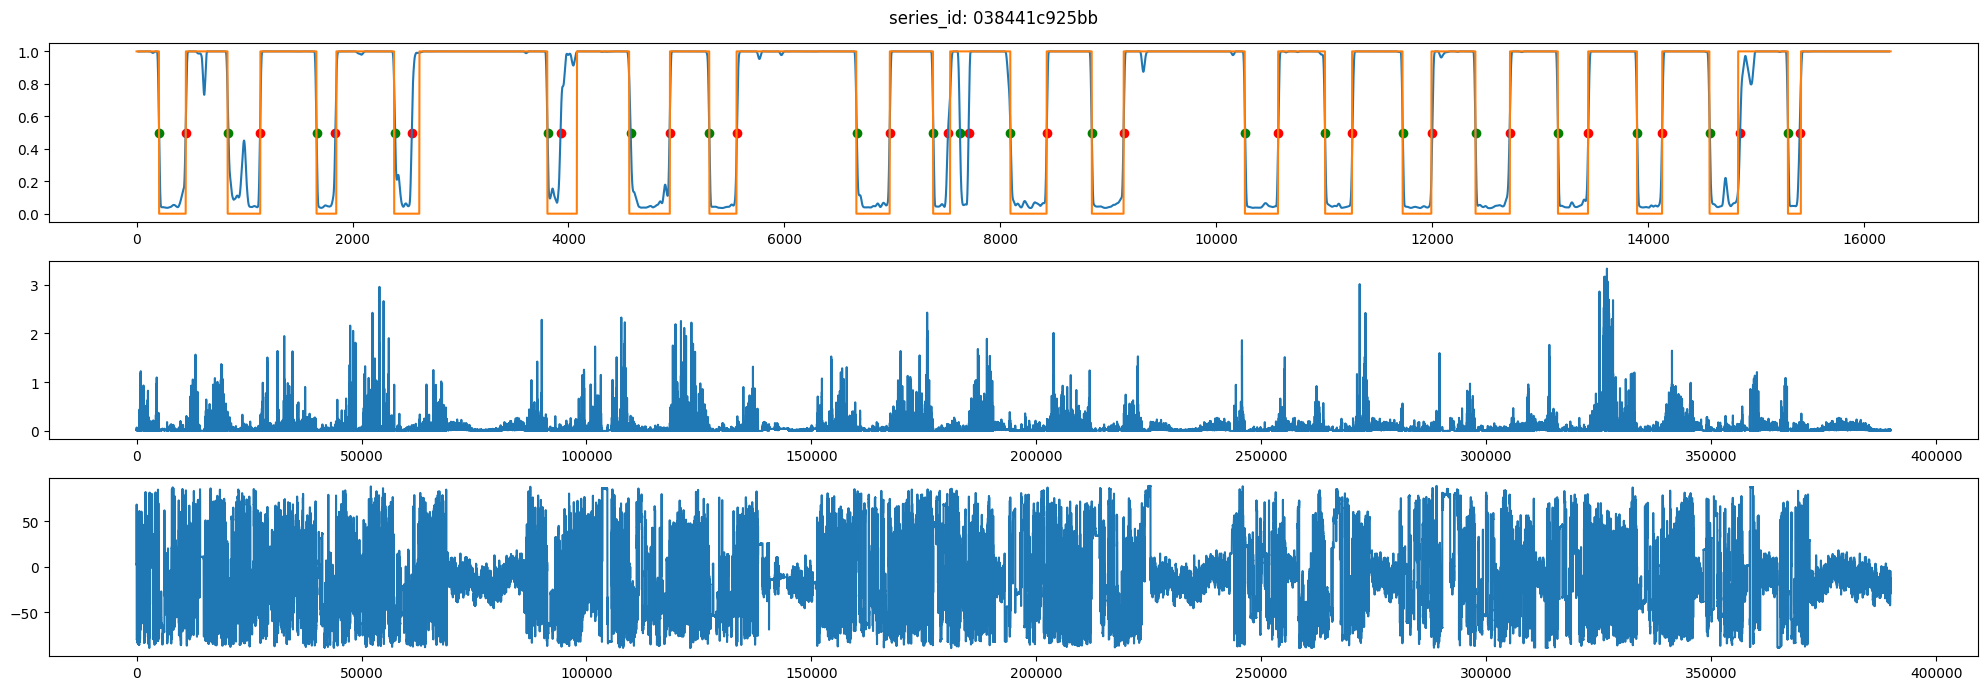

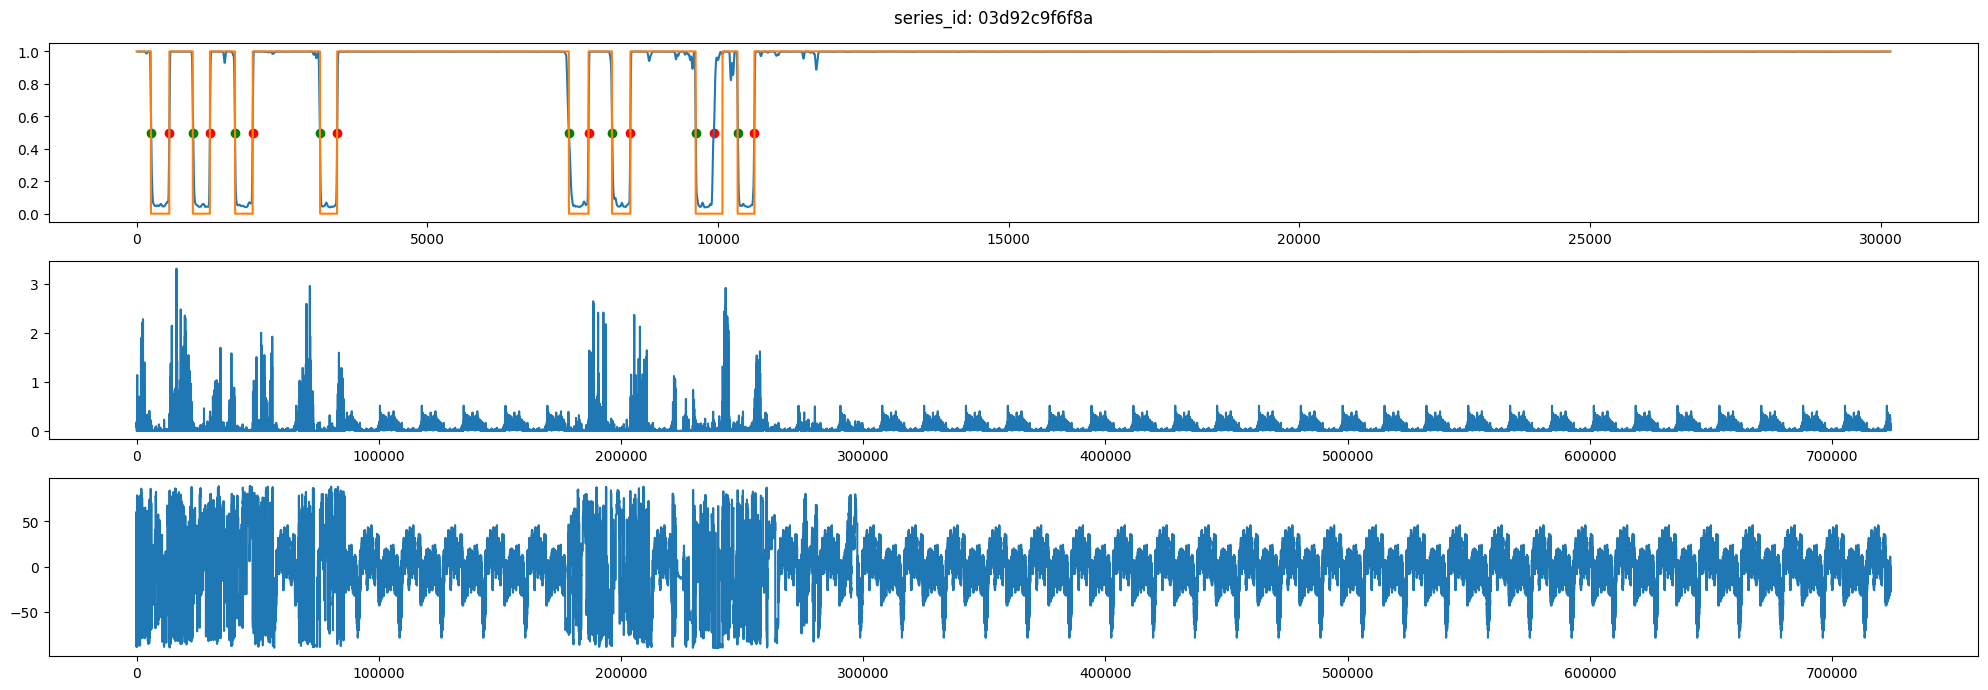

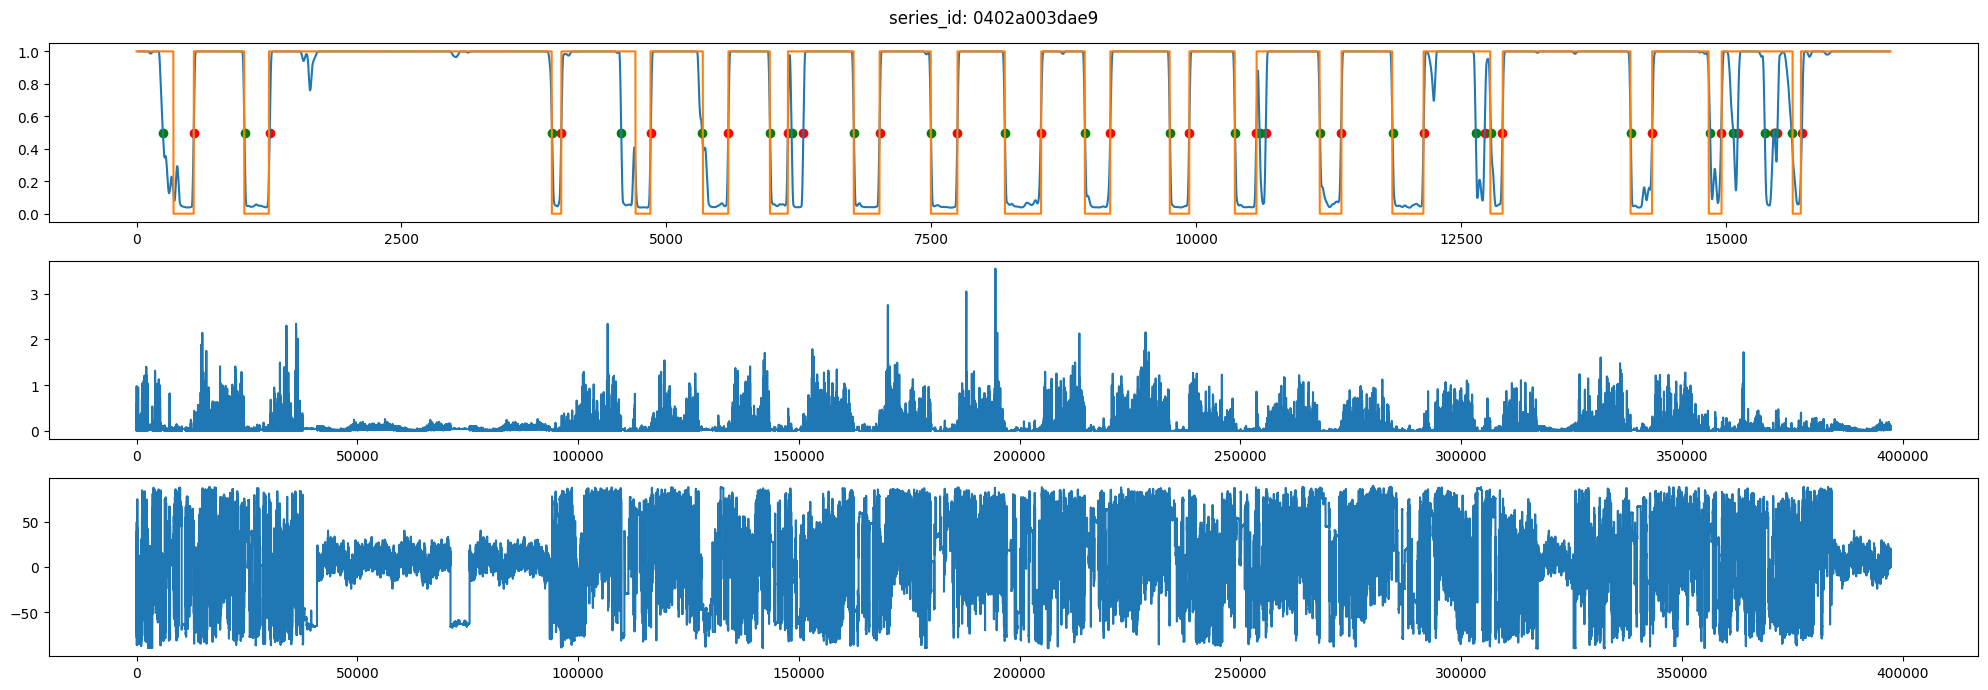

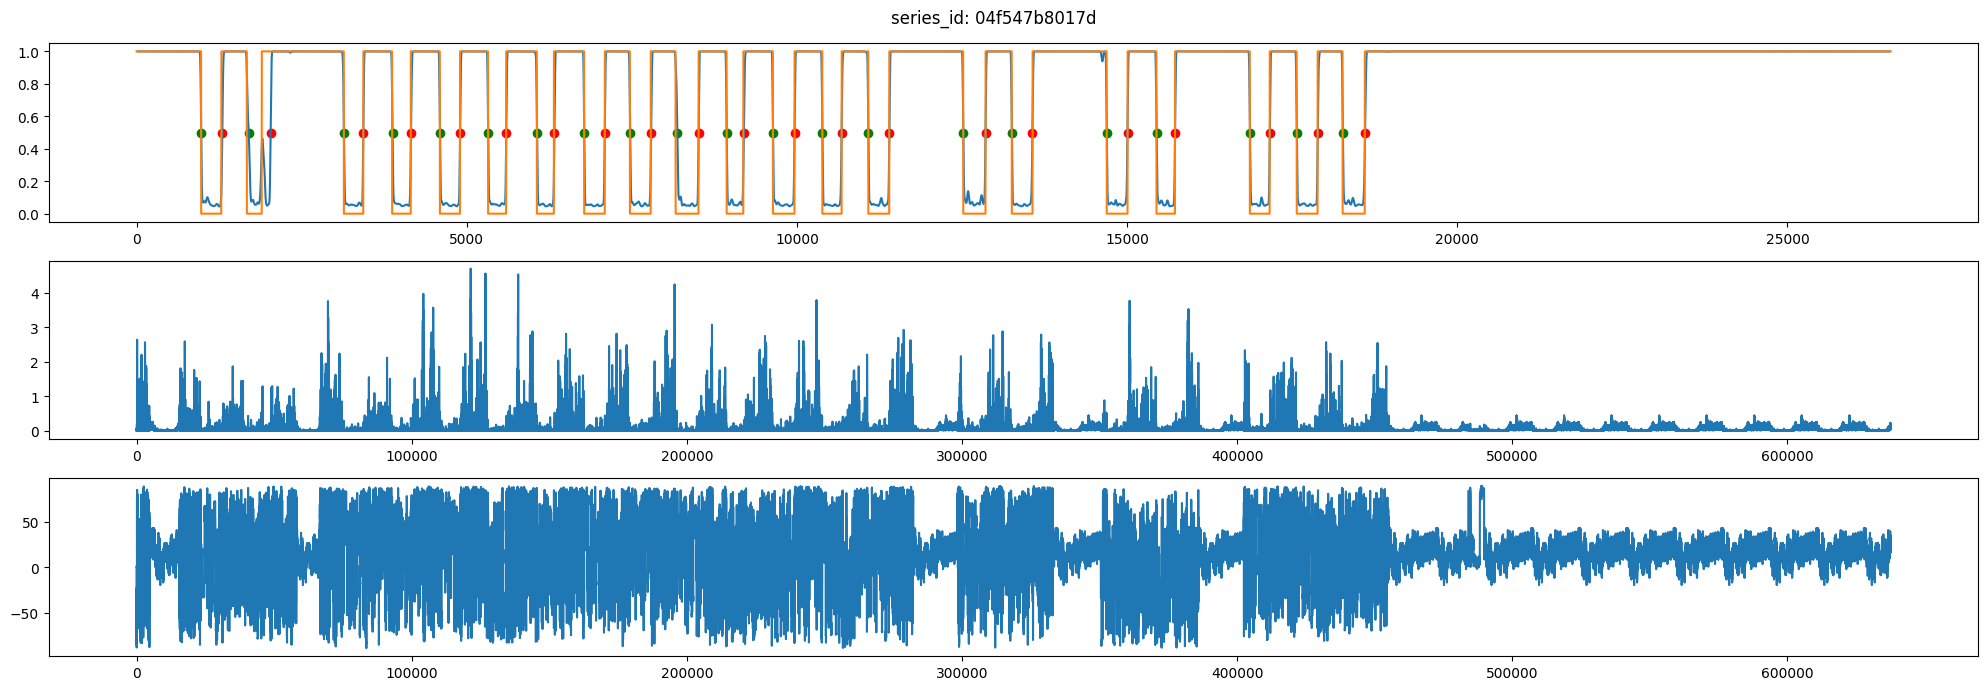

,series_id,step,event,score
0,038441c925bb,10919,wakeup,1
1,038441c925bb,27455,wakeup,1
2,038441c925bb,44207,wakeup,1
3,038441c925bb,61175,wakeup,1
4,038441c925bb,94247,wakeup,1


In [ ]:
dfs = []
oofs = []
for series_id, df in train.groupby("series_id"):
    df = df.reset_index(drop=True)
    df["raw_oof"] = df["oof"]
    df["oof"] = df["raw_oof"].rolling(12, center=True).mean()
    oofs.append(df)
    wakeup_index = np.array([i for i in range(1, len(df["oof"])) if df["oof"][i-1] < 0.5 and df["oof"][i] >= 0.5])
    onset_index = np.array([i for i in range(1, len(df["oof"])) if df["oof"][i-1] > 0.5 and df["oof"][i] <= 0.5])

    sub = pd.concat([
        pd.DataFrame({
            "series_id": series_id,
            "step": df["step"].values[wakeup_index] - CFG["feature"]["agg_freq"] // 2,
            "event": "wakeup",
            "score": 1,
        }) if len(wakeup_index) > 0 else pd.DataFrame(),
        pd.DataFrame({
            "series_id": series_id,
            "step": df["step"].values[onset_index] - CFG["feature"]["agg_freq"] // 2,
            "event": "onset",
            "score": 1,
        }) if len(onset_index) > 0 else pd.DataFrame(),
    ])
    if len(sub) > 0:
        sub["step"] = sub["step"].astype(int)
        dfs.append(sub)

    if len(dfs) < 5:
        fig, axs = plt.subplots(3, 1, figsize=(20, 7))
        axs[0].plot(df["oof"])
        axs[0].plot(df["target"])
        axs[0].scatter(wakeup_index, [0.5 for _ in wakeup_index], c="red")
        axs[0].scatter(onset_index, [0.5 for _ in onset_index], c="green")
        df = pd.read_csv(f"{CFG['dataset']['step_csv_dir']}/{df['series_id'].values[0]}.csv")
        axs[1].plot(df["enmo"])
        axs[2].plot(df["anglez"])
        plt.suptitle(f"series_id: {series_id}")
        plt.tight_layout()
        plt.show()

train = pd.concat(oofs)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)
sub = pd.concat(dfs).reset_index(drop=True)
sub.head()

score: 0.4961


event   tolerance
onset   12           0.005671
        36           0.086392
        60           0.279744
        90           0.417832
        120          0.537491
        150          0.585035
        180          0.628954
        240          0.679002
        300          0.709885
        360          0.729282
wakeup  12           0.044016
        36           0.231859
        60           0.375090
        90           0.496640
        120          0.576307
        150          0.625827
        180          0.665431
        240          0.720239
        300          0.753069
        360          0.774784
dtype: float64

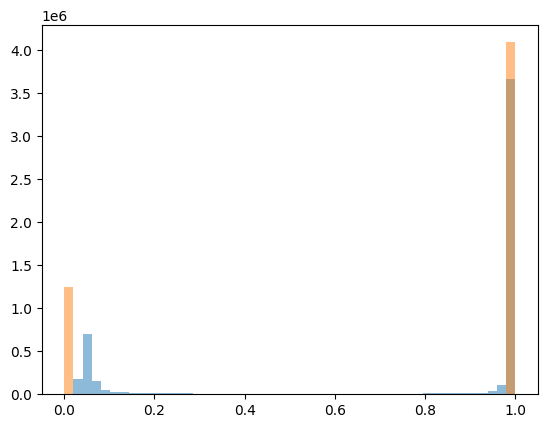

In [ ]:
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)
print(f"score: {score:.4f}")
display(ap_table)
plt.hist(train["oof"], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.hist(train["target"], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.show()